### Bayesian linear regression on CPU data

 * #### Aims
     - To implement Bayesian inference over the parameters of the linear model for the CPU data.


#### Task 1:  Bayesian treatment of the CPU regression problem
In this task, we will perform a Bayesian treatment of the CPU regression problem. 

#####  We start by loading the data and rescaling it to aid with numerics.

In [2]:
import numpy as np
import pylab as plt
%matplotlib inline
np.random.seed(1)


X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

MYCT = X_train[:,0][:,None]
MMIN = X_train[:,1][:,None]
MMAX = X_train[:,2][:,None]
CACH = X_train[:,3][:,None]
CHMIN = X_train[:,4][:,None]
CHMAX = X_train[:,5][:,None]

print(X_train.shape)
print(Y_train.shape)

(168, 6)
(168, 1)


##### Task 1.1: Step up prior, $p(\mathbf{w})$

We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cccccc} 1&8&1&6&2&9\\4&5&5&5&6&5\\10&1&10&21&10&19  \\9&1&1&10&10&10   \\ 10&0&10&0&10&0  \\  0&20&0&2&10&10  \\     \end{array}\right]$. We'll also fix $\sigma^2=2$.

In [3]:
prior_mean = np.zeros((6,1)) # vector of mean 
prior_cov = np.array([[1,8,1,6,2,9],[4,5,5,5,6,5],[10,1,10,21,10,19],[9,1,1,10,10,10],[10,0,10,0,10,0],[0,20,0,2,10,10]]) # covariance matrix
print(prior_cov.shape)
print(np.linalg.det(prior_cov))
sig_sq = 2 # variance of the additive noise 

(6, 6)
137760.00000000052


##### Task 1.2: Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models with all features
Use `numpy`'s `multivariate_normal` to generate samples from a multivariate Gaussian 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html

C:\Users\yingt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


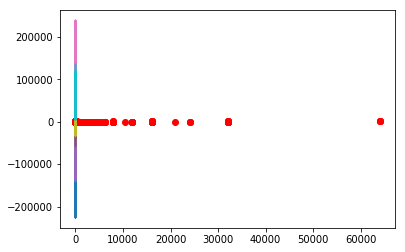

In [4]:
w_samp = np.random.multivariate_normal(prior_mean.flatten(),prior_cov,10) # sampling from multivariate Gaussian distribution 
plt.figure()
plt.plot(X_train,Y_train,'ro') # plot data 
plot_x = X_test # generate new x for plotting the sampled model, e.g. you need construct design matrix for any new x
plt.plot(np.dot(w_samp,plot_x.T).T)

##### Task 1.3: Compute the posterior and draw samples from it

First let's write functions to construct polynomial design matrix, and to compute posterior mean and covariance 
$$\mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X}^{T}\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$$
$$\boldsymbol\mu = \frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^{T}\mathbf{t}$$
where $\mathbf{S}$ is the covariance matrix of the prior $p(\mathbf{w})$

In [5]:
def compute_post_cov(X, prior_cov, sig_sq): # your own function to compute posterior mean
    return(np.linalg.inv((1.0/sig_sq)*np.dot(X.T,X) + np.linalg.inv(prior_cov)) )
 
def compute_post_mean(post_cov, sig_sq, X, t): # your own function to compute posterior covariance
    return(np.dot(post_cov,(1.0/sig_sq)*np.dot(X.T,t) ) )

C:\Users\yingt\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  


''

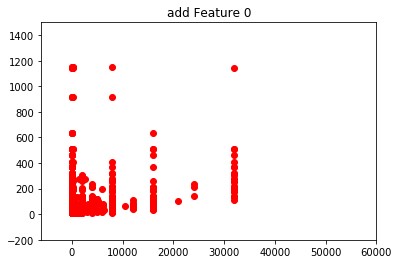

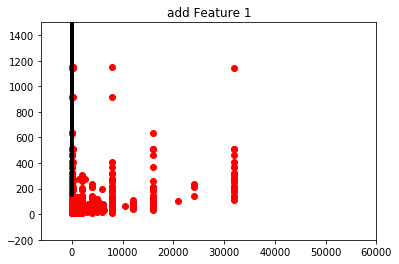

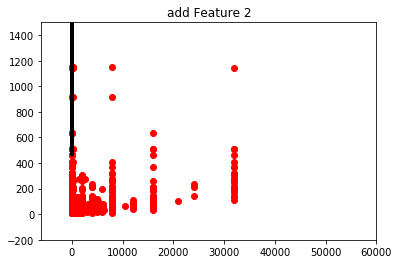

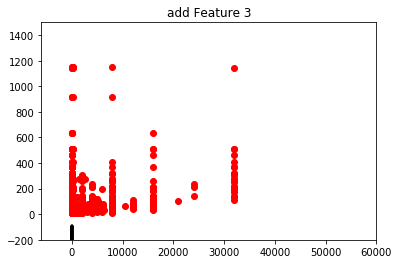

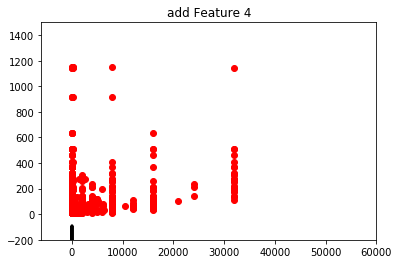

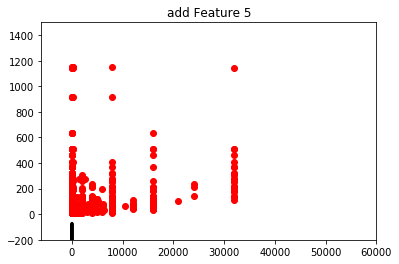

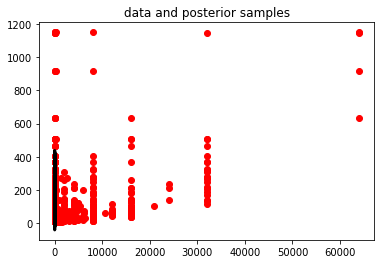

In [6]:
# new x to predict 
def polynomial(x, max_order): # your own function to construct polynomial design matrix
    X = np.ones_like(x[:,0][:,None])
    for i in range(max_order):
        X = np.hstack((X,x[:,i][:,None]))
    return(X)

max_order = 6 # array of possible orders
for i in range(max_order):
    X = polynomial(X_train, i) # construct polynoimals on training data
    post_cov = compute_post_cov(X, prior_cov[0:i+1:,0:i+1:], sig_sq) # compute posterior mean 
    
    post_mean = compute_post_mean(post_cov,sig_sq,X,Y_train) # compute posterior covariance
    w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) # draw some samples
    
    
    plt.figure()
    plt.title("add Feature " + str(i))
    
    
    plt.xlim([-6000,60000])
    plt.ylim([-200,1500])
    plt.plot(X_train,Y_train,'ro')
    plt.plot(np.dot(w_samp,X_test[::,0:i+1:].T).T,'b') # plot the sampled lines, 
                                                   # only need 2 points to plot a straight line
    plt.plot(np.dot(X_test[::,0:i+1:],post_mean),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line 





''''''
X = X_train # construct design matrix
post_cov = compute_post_cov(X, prior_cov, sig_sq) # compute posterior mean 
post_mean = compute_post_mean(post_cov,sig_sq,X,Y_train) # compute posterior covariance 

plt.figure()
plt.title('data and posterior samples') 
w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) # draw some samples
plt.plot(X_train,Y_train,'ro')
plt.plot(np.dot(w_samp,X_test.T).T,'b') # plot the sampled lines, 
                                               # only need 2 points to plot a straight line
plt.plot(np.dot(X_test,post_mean),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line 
''''''


#### Task 2: We'll now look at predictions

##### Task 2.1: Functions for posterior prediction

$$p(t_{new} | \mathbf{X},\mathbf{t},\mathbf{x}_{new},\sigma^2) = {\cal N}(\mathbf{x}_{new}^{T}\boldsymbol\mu,\sigma^2 + \mathbf{x}_{new}^{T}  \mathbf{\Sigma} \mathbf{x}_{new})$$

In [7]:
testX = X_test # generate some test data

pred_mean = np.dot(testX, post_mean) # compute predictive mean
pred_var = sig_sq + np.diag(np.dot(testX,np.dot((post_cov),testX.T))) # compute predictive variance 

#### Task 2.2: Plot error bars 

<Container object of 3 artists>

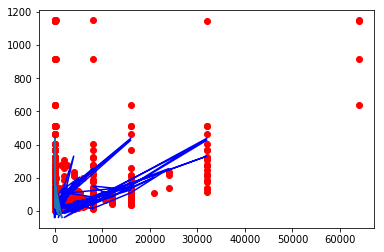

In [8]:
plt.plot(X_train,Y_train,'ro') # plot data 
plt.plot(X_test,pred_mean,'b') # plot mean prediction 
plt.errorbar(X_test[:,0][:,None].flatten(),pred_mean.flatten(),yerr=pred_var.flatten()) # plot error bars 

In [9]:
w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) 
Y_predict = np.dot(testX,w_samp.T)
print(Y_predict.shape)

(41, 1)


#### Task 2.3: Generate prediction

In [10]:
test_header = "Id,PRP"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = Y_predict[:,0]
print(y_pred_pp)
np.savetxt('my_submission_b.csv', y_pred_pp, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.         134.77396931]
 [  1.         203.11136198]
 [  2.          39.0650161 ]
 [  3.          32.12687797]
 [  4.         -15.00621639]
 [  5.          39.87947011]
 [  6.         171.05792085]
 [  7.         -39.43183153]
 [  8.         116.2995667 ]
 [  9.          17.56264756]
 [ 10.          70.96813451]
 [ 11.          32.28874317]
 [ 12.          19.30458278]
 [ 13.          74.2763446 ]
 [ 14.          54.86459335]
 [ 15.          71.8637184 ]
 [ 16.         426.37141454]
 [ 17.          81.60631192]
 [ 18.         437.72688034]
 [ 19.          63.0250431 ]
 [ 20.          29.55766925]
 [ 21.         -22.37970217]
 [ 22.          37.89682054]
 [ 23.         144.91257949]
 [ 24.         108.03201349]
 [ 25.          83.96425037]
 [ 26.         330.76568175]
 [ 27.          16.55078536]
 [ 28.         255.02724751]
 [ 29.         109.37692104]
 [ 30.          14.46708935]
 [ 31.          40.65015681]
 [ 32.          21.65495689]
 [ 33.         126.64592033]
 [ 34.        

#### Task 2.4: get average squared loss
- Average squared loss: $L(\mathbf{w}) = \frac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w})^T(\mathbf{t} - \mathbf{X}\mathbf{w})$


the average squared loss on 1 feature: 28332.145821813094
the average squared loss on 2 feature: 25706.806422205835
the average squared loss on 3 feature: 10498.054987786127
the average squared loss on 4 feature: 5500.088097386363
the average squared loss on 5 feature: 4671.774783338873
the average squared loss on 6 feature: 4621.967694926144


C:\Users\yingt\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  


Text(0.5,1,'Bayesian Linear Regression Model')

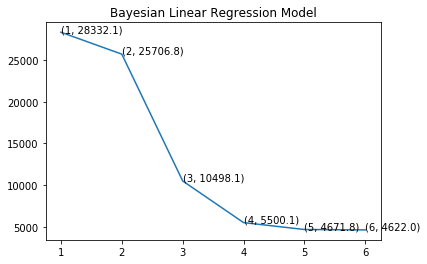

In [11]:
def loss(w, X, t): # define the loss function
    w = w.T
    L = np.mean( (t-np.dot(X, w))**2 ) # the average squared loss function
    return(L)

orders = max_order
loss_buff = []
index = []
for i in range(orders):
    X = polynomial(X_train, i) # construct polynoimals on training data
    post_cov = compute_post_cov(X, prior_cov[0:i+1:,0:i+1:], sig_sq) # compute posterior mean 
    
    post_mean = compute_post_mean(post_cov,sig_sq,X,Y_train) # compute posterior covariance
    w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) # draw some samples
    
    loss_value = loss(w_samp,X,Y_train)
    loss_buff.append(round(loss_value,1))
    index.append(i+1)
    print("the average squared loss on "+ str(i+1)+" feature: " + str(loss_value) )
    

    
    
plt.figure()
ax = plt.figure().add_subplot(111)
plt.plot(index, loss_buff)
for xy in zip(index, loss_buff):                                       # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') # <--
plt.title('Bayesian Linear Regression Model')

#print("the average squared loss: ", loss(w_samp,X_train,Y_train)) # my gradient output


#### Task 3: make X_train with 4 features by combining feature

In [12]:
MYCT = X_train[:,0][:,None]
MMIN = X_train[:,1][:,None]
MMAX = X_train[:,2][:,None]
CACH = X_train[:,3][:,None]
CHMIN = X_train[:,4][:,None]
CHMAX = X_train[:,5][:,None]
Average_N_CH = (CHMIN + CHMAX)/2
Average_M_M = (MMIN+MMAX)/2

# allocate new X_train with 4 features
X_new_train = MYCT
X_new_train = np.hstack((X_new_train,Average_M_M))
X_new_train = np.hstack((X_new_train,CACH))
X_new_train = np.hstack((X_new_train,Average_N_CH))
# allocate new Y_train with original Y_train
Y_new_train = Y_train


MYCT_test = X_test[:,0][:,None]
MMIN_test = X_test[:,1][:,None]
MMAX_test = X_test[:,2][:,None]
CACH_test = X_test[:,3][:,None]
CHMIN_test = X_test[:,4][:,None]
CHMAX_test = X_test[:,5][:,None]
Average_N_CH_test = (CHMIN_test + CHMAX_test)/2
Average_M_M_test = (MMIN_test+MMAX_test)/2

# allocate new X_test with 4 features
X_new_test = MYCT_test
X_new_test = np.hstack((X_new_test,Average_M_M_test))
X_new_test = np.hstack((X_new_test,CACH_test))
X_new_test = np.hstack((X_new_test,Average_N_CH_test))


##### Task 3.1: Step up prior, $p(\mathbf{w})$

We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cccc} 1&1&1&2 \\4 & 5&5&1\\1&1&10&1 \\ 1&1&1&10 \end{array}\right]$. We'll also fix $\sigma^2=2$.

In [13]:
prior_mean_new = np.zeros((4,1)) # vector of mean 
prior_cov_new = np.array([[1,1,1,2],[4,5,5,1],[1,1,10,1],[1,1,1,10]]) # covariance matrix
print(prior_cov_new.shape)
print(np.linalg.det(prior_cov_new))
sig_sq = 2 # variance of the additive noise 

(4, 4)
72.0


##### Task 3.2: Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models with all features
Use `numpy`'s `multivariate_normal` to generate samples from a multivariate Gaussian 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html

C:\Users\yingt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


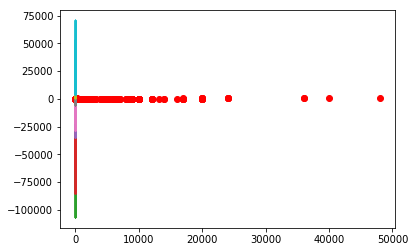

In [14]:
w_samp = np.random.multivariate_normal(prior_mean_new.flatten(),prior_cov_new,10) # sampling from multivariate Gaussian distribution 
plt.figure()
plt.plot(X_new_train,Y_new_train,'ro') # plot data 
plot_x = X_new_test # generate new x for plotting the sampled model, e.g. you need construct design matrix for any new x
plt.plot(np.dot(w_samp,plot_x.T).T)

##### Task 3.3: Compute the posterior and draw samples from it

First let's write functions to construct polynomial design matrix, and to compute posterior mean and covariance 
$$\mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X}^{T}\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$$
$$\boldsymbol\mu = \frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^{T}\mathbf{t}$$
where $\mathbf{S}$ is the covariance matrix of the prior $p(\mathbf{w})$

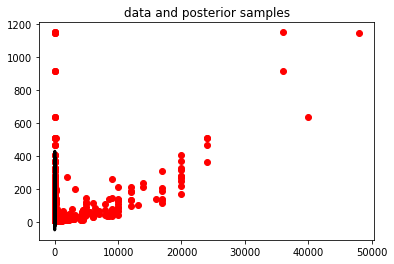

In [15]:
X = X_new_train # construct design matrix
post_cov_new = compute_post_cov(X, prior_cov_new, sig_sq) # compute posterior mean 
post_mean_new = compute_post_mean(post_cov_new,sig_sq,X,Y_new_train) # compute posterior covariance 

plt.figure()
plt.title('data and posterior samples') 
w_samp = np.random.multivariate_normal(post_mean_new.flatten(),post_cov_new,1) # draw some samples
plt.plot(X_new_train,Y_new_train,'ro')
plt.plot(np.dot(w_samp,X_new_test.T).T,'b') # plot the sampled lines, 
                                               # only need 2 points to plot a straight line
plt.plot(np.dot(X_new_test,post_mean_new),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line 

#### Task 4: We'll now look at predictions

##### Task 4.1: Functions for posterior prediction

$$p(t_{new} | \mathbf{X},\mathbf{t},\mathbf{x}_{new},\sigma^2) = {\cal N}(\mathbf{x}_{new}^{T}\boldsymbol\mu,\sigma^2 + \mathbf{x}_{new}^{T}  \mathbf{\Sigma} \mathbf{x}_{new})$$

In [16]:
testX = X_new_test # generate some test data

pred_mean_new = np.dot(testX, post_mean_new) # compute predictive mean
pred_var_new = sig_sq + np.diag(np.dot(testX,np.dot((post_cov_new),testX.T))) # compute predictive variance 


#### Task 4.2: Plot error bars 

<Container object of 3 artists>

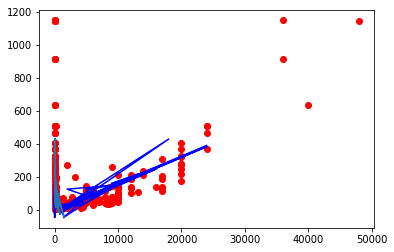

In [17]:
plt.plot(X_new_train,Y_new_train,'ro') # plot data 
plt.plot(X_new_test,pred_mean_new,'b') # plot mean prediction 
plt.errorbar(X_new_test[:,0][:,None].flatten(),pred_mean_new.flatten(),yerr=pred_var_new.flatten()) # plot error bars 

In [18]:
w_samp = np.random.multivariate_normal(post_mean_new.flatten(),post_cov_new,1) 
Y_predict_new = np.dot(X_new_test,w_samp.T)
print(Y_predict_new.shape)

(41, 1)


#### Task 4.3: Generate prediction

In [19]:
test_header = "Id,PRP"
n_points = X_new_test.shape[0]
y_pred_pp_new = np.ones((n_points, 2))
y_pred_pp_new[:, 0] = range(n_points)
y_pred_pp_new[:, 1] = Y_predict_new[:,0]
print(y_pred_pp_new)
np.savetxt('my_submission_new_b.csv', y_pred_pp_new, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.         160.9524016 ]
 [  1.         216.98123203]
 [  2.          49.47484132]
 [  3.          37.71768815]
 [  4.         -13.91118703]
 [  5.          52.00769035]
 [  6.         171.63657225]
 [  7.         -47.147381  ]
 [  8.         131.14414392]
 [  9.          13.66089454]
 [ 10.          80.54336218]
 [ 11.          23.85671091]
 [ 12.          12.63619935]
 [ 13.          71.29495084]
 [ 14.          48.71689425]
 [ 15.          70.09373899]
 [ 16.         383.64440074]
 [ 17.          97.64448636]
 [ 18.         390.70535629]
 [ 19.          75.38805774]
 [ 20.          28.58145566]
 [ 21.         -26.67080881]
 [ 22.          41.92206006]
 [ 23.         150.933712  ]
 [ 24.         124.81522855]
 [ 25.          85.35866054]
 [ 26.         429.16815446]
 [ 27.          15.4996718 ]
 [ 28.         247.4725701 ]
 [ 29.         128.51047281]
 [ 30.          26.49691248]
 [ 31.          40.18952098]
 [ 32.          25.36930345]
 [ 33.         148.17564772]
 [ 34.        

#### Task 4.4: get average squared loss

the average squared loss on 1 feature: 28331.892132614434
the average squared loss on 2 feature: 25706.87514925651
the average squared loss on 3 feature: 5592.877188559198
the average squared loss on 4 feature: 4696.479041287752


C:\Users\yingt\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


Text(0.5,1,'Bayesian Linear Regression Model')

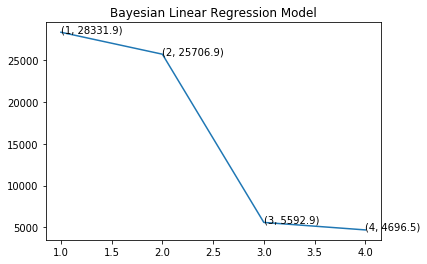

In [20]:

orders = 4
loss_buff = []
index = []
for i in range(orders):
    X = polynomial(X_new_train, i) # construct polynoimals on training data
    post_cov = compute_post_cov(X, prior_cov[0:i+1:,0:i+1:], sig_sq) # compute posterior mean 
    post_mean = compute_post_mean(post_cov,sig_sq,X,Y_train) # compute posterior covariance
    w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) # draw some samples
    
    loss_value = loss(w_samp,X,Y_train)
    loss_buff.append(round(loss_value,1))
    index.append(i+1)
    print("the average squared loss on "+ str(i+1)+" feature: " + str(loss_value) )
    

    
    
plt.figure()
ax = plt.figure().add_subplot(111)
plt.plot(index, loss_buff)
for xy in zip(index, loss_buff):                                       # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') # <--
plt.title('Bayesian Linear Regression Model')